In [27]:
import subprocess
from matplotlib import pyplot as plt
import os
import numpy as np

search_term_population = "Mulliken spin population per centre and basis function type"
lines_after_population=185

def search_in_file(file_path, search_term, lines_after):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    results = []
    for i, line in enumerate(lines):
        if search_term in line:
            # Add the matching line
            results.append(line.strip())
            # Add up to `lines_after` lines after the match
            results.extend(line.strip() for line in lines[i+1:i+1+lines_after])
    
    return results

def population_summation(results):
    all_data = []
    for i in range(len(results)):
        if results[i] == 'Mulliken spin population per centre and basis function type':
            populations = []
            s = 0.0
            p = 0.0
            d = 0.0
            f = 0.0
            for t in range(181):

                if results[i+t+4] == '':
                    continue
                elif results[i+t+4][1] == 's':
                    s = s + float(results[i+t+4][9:15])
                elif results[i+t+4][1] == 'p':
                    p = p + float(results[i+t+4][9:15])
                elif results[i+t+4][1] == 'd':
                    d = d + float(results[i+t+4][9:15])
                elif results[i+t+4][1] == 'f':
                    f = f + float(results[i+t+4][9:15])
                else:
                    continue
            populations.append(s)
            populations.append(p)
            populations.append(d)
            populations.append(f)
            all_data.append(populations)
        else:
            continue
    return all_data

def rasscf_energies(results):
    energies = []
    for i in range(9):
        energies.append(-abs(float(results[i+3][44:57])))
    return energies


search_term_rasscf = "Final state energy(ies):"
lines_after_rasscf=11

def move_item_in_list(lst, old_index, new_index):
    """
    This function is used to reorganise certain elements of lists.
    Used for reorganising the files
    """
    item = lst.pop(old_index)  # Remove the item from old position
    lst.insert(new_index, item)  # Insert at new position
    return lst

def get_files(element: str) -> list:
    folder_path = "C:\\Users\\Mikel\\Documents\\00 - Universidades\\2 - RUG_Physics\\2024 - 2025\\Research Internship\\Initial simulations and tryouts\\1 electron\\non_rel_basis_9_active_Madelung\\correct_data_from_sims"
    files = ["\\" + item for item in [file for file in os.listdir(folder_path) if element in file]]
    return files

############################
# Bond Length factors list #
############################

def plotting_separated_graphs(V_positions, V_Energies, V_population_total, elem):
    print("Red is the s-orbital")
    print("Green is the p-orbital")
    print("Blue is the d-orbital")
    print("Black is the f-orbital")
    # Define the colors for each segment
    colors = ['red', 'green', 'blue', 'black']

    fig, ax = plt.subplots(3,3, figsize=(20,20), facecolor ='white')
    i=0
    j=0
    for pos, ener, population, elem in zip(V_positions, V_Energies, V_population_total, elem):

        for pos, ener, population in zip(pos, ener, population):

            points = [0]
            for ratio in population:
                points.append(points[-1] + 0.4 * ratio)

            x_values = []
            y_values = []
            # Plot each segment with its respective color
            for t in range(len(colors)):
                x_values = np.linspace(pos+points[t], pos+points[t + 1], 100)
                y_values = np.full_like(x_values, ener)  # Specific value for y
                ax[i,j].plot(x_values, y_values, color=colors[t], linewidth=3.5)

            ax[i, j].set_title(f'Energy levels for {elem}')
            ax[i, j].set_ylabel("Energy (Ev)")
            ax[i, j].set_xticks([0.5], ['CF'])
            ax[i, j].set_xlim(-1.0, 2.0)
        j = j +1
        if j == 3:
            j = 0
            i = i +1

    plt.show()

def plotting_joint_graphs(V_positions, V_Energies, V_bond_lengths_factors_list):
    normaliser_ground_value = V_Energies[19][0]
    fig, ax= plt.subplots(figsize=(30,10))
    i=0
    t=0
    #This is used for a dual y-axis, after the 6th measurement the axis are relabeled
    ax2 = ax.twinx()
    for pos, ener in zip(V_positions, V_Energies):
        if t >= 6:
            diff = ener[0] - normaliser_ground_value
            for j in range(len(pos)):
                pos[j] = pos[j] + i
                ener[j] = ener[j] - diff
            ax2.scatter(pos, ener, s=100, marker="_", linewidth=1.5, zorder=3)
        else:
            diff = ener[0] - normaliser_ground_value
            for j in range(len(pos)):
                pos[j] = pos[j] + i
                ener[j] = ener[j] - diff
            ax.scatter(pos, ener, s=100, marker="_", linewidth=1.5, zorder=3)
        i=i+3
        t=t+1
    plt.title("Energy levels with reescaling after 6th trial", fontsize=25)
    V_positions_xticks = [0.5,3.5,6.5,9.5,12.5,15.5,18.5,21.5,24.5,27.5,30.5,33.5,36.5,39.5,42.5,45.5,48.5,51.5,54.5,57.5]
    plt.xticks(V_positions_xticks, V_bond_lengths_factors_list)
    plt.axvline(17)
    plt.show()

def assign_positions_to_energy_values_based_on_their_relative_differences(numbers, threshold):
    
    # Step 1: Sort numbers
    numbers = sorted(numbers)

    # Step 2: Group numbers based on relative difference
    groups = []
    current_group = [numbers[0]]

    for i in range(1, len(numbers)):
        if abs(numbers[i] - current_group[-1]) <= threshold:
            current_group.append(numbers[i])
        else:
            groups.append(current_group)
            current_group = [numbers[i]]
    
    groups.append(current_group)  # Add the last group

    # Step 3: Assign values based on group size
    assignment_map = {
        1: [0.5],
        2: [0, 1],
        3: [0, 0.5, 1],
        5: [-0.5, 0, 0.5, 1, 1.5]
    }

    assigned_values = []
    for group in groups:
        size = len(group)
        if size in assignment_map:
            assigned_values.extend(assignment_map[size])
        else:  
            # If size is not in predefined mapping, distribute evenly
            assigned_values.extend(np.linspace(0, 1, size).tolist())

    return assigned_values

# Processing

Red is the s-orbital
Green is the p-orbital
Blue is the d-orbital
Black is the f-orbital


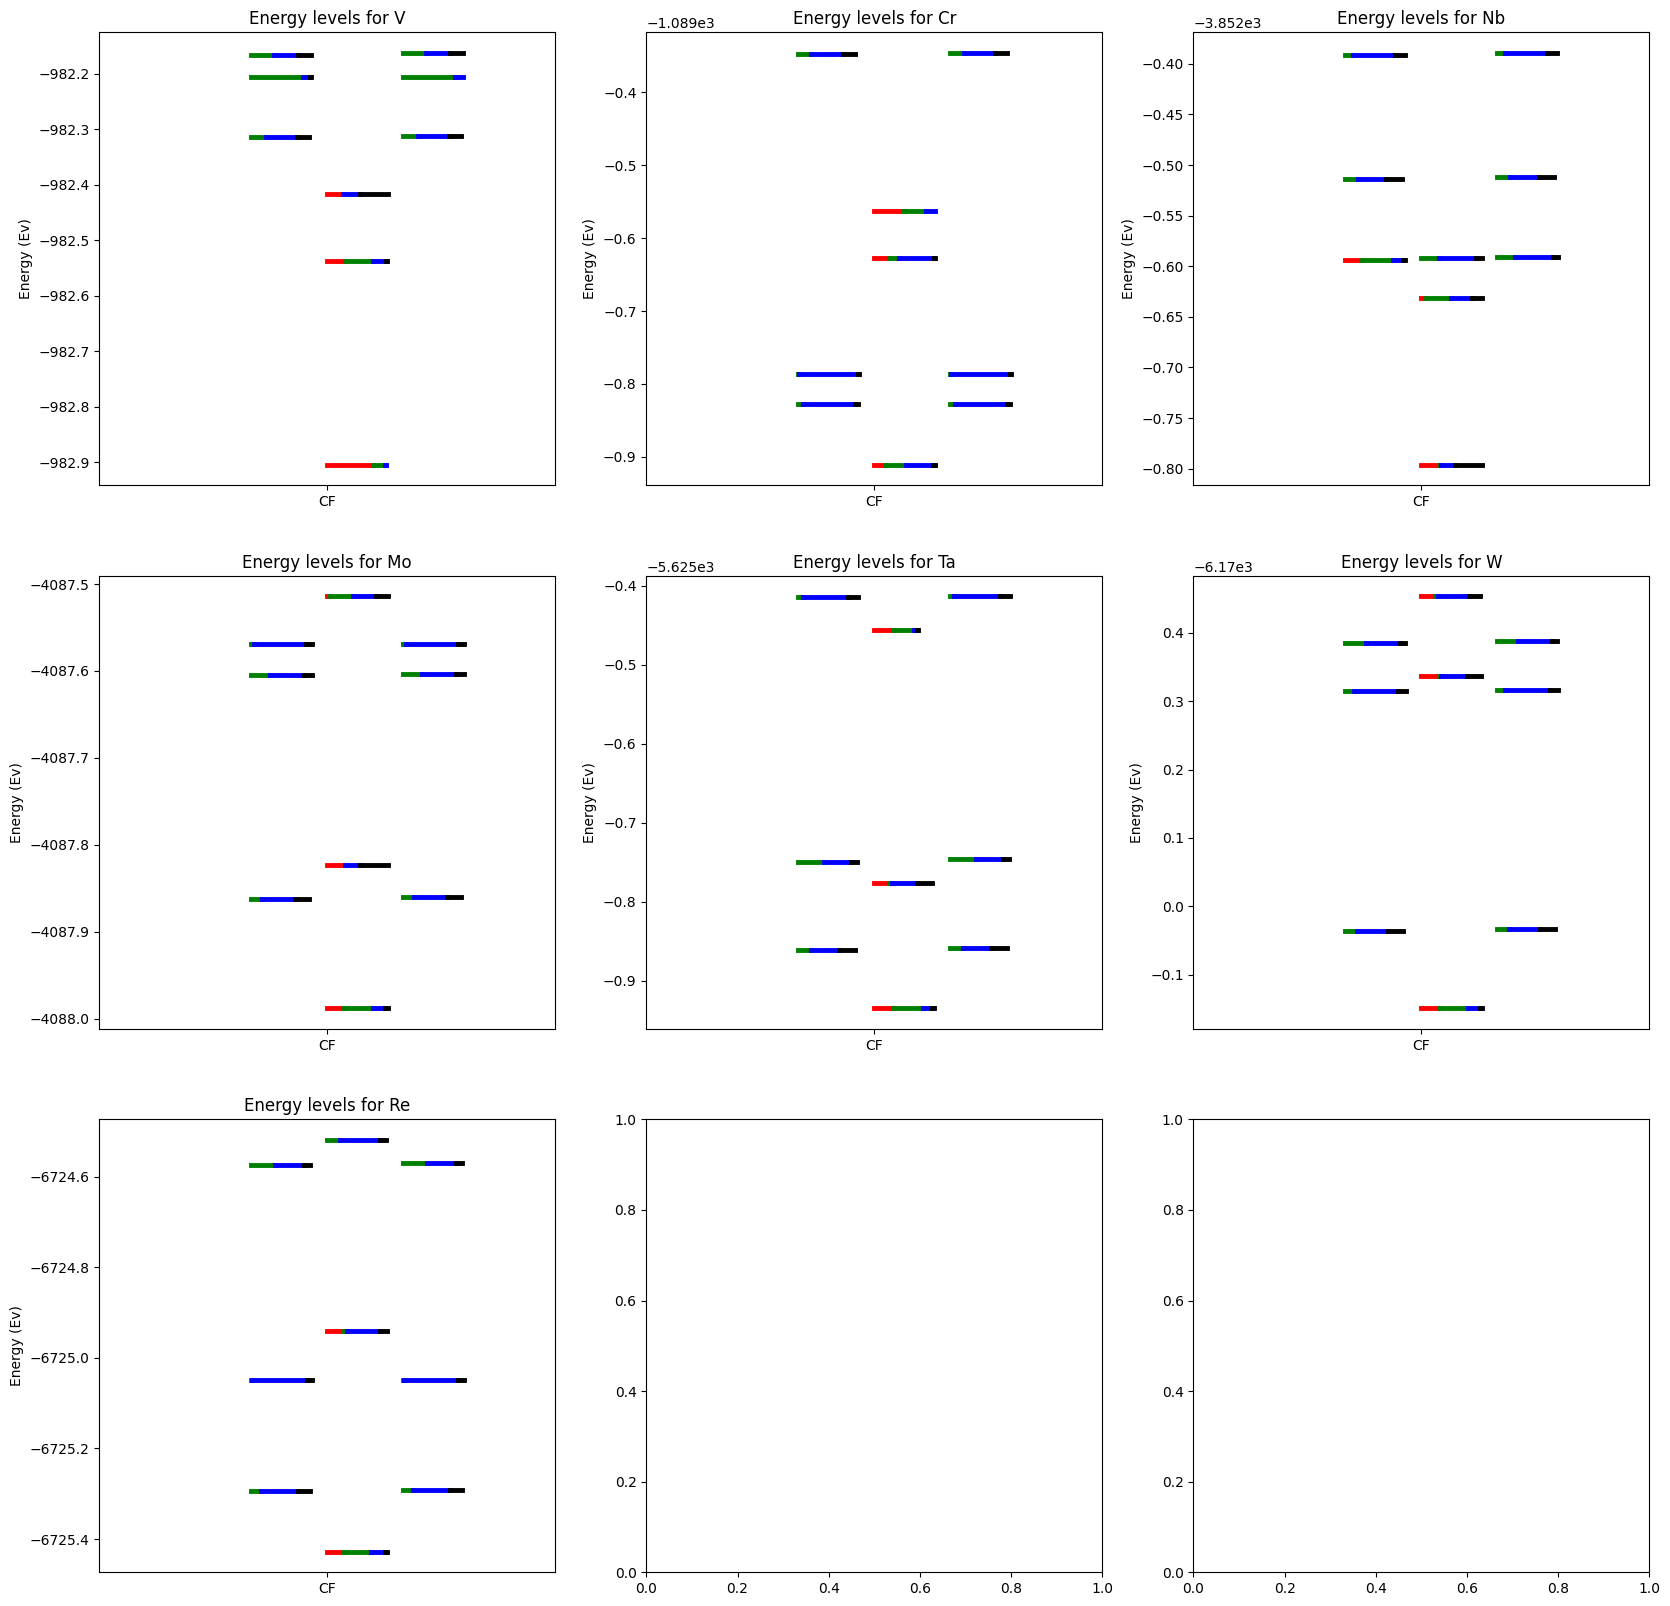

In [45]:
unordered_files  = get_files("madelung")
order = [6, 0, 2, 1, 4, 5, 3]  # Custom order
files = []
for i in order:
    files.append(unordered_files[i])

V_Energies = []
V_population_total = []
for i in range(len(files)):
    V_Energies.append(rasscf_energies(search_in_file(r'c:\Users\Mikel\Documents\00 - Universidades\2 - RUG_Physics\2024 - 2025\Research Internship\Initial simulations and tryouts\1 electron\non_rel_basis_9_active_Madelung\correct_data_from_sims' + files[i], search_term_rasscf, lines_after_rasscf)))
    V_population_total.append(population_summation(search_in_file(r'c:\Users\Mikel\Documents\00 - Universidades\2 - RUG_Physics\2024 - 2025\Research Internship\Initial simulations and tryouts\1 electron\non_rel_basis_9_active_Madelung\correct_data_from_sims' + files[i], search_term_population, lines_after_population)))

V_positions = []
for i in range(len(V_Energies)):
    V_positions.append(assign_positions_to_energy_values_based_on_their_relative_differences(V_Energies[i], threshold=0.01))


plotting_separated_graphs(V_positions, V_Energies, V_population_total, ["V", "Cr", "Nb", "Mo", "Ta", "W", "Re"])